In [1]:
import os

In [2]:
%pwd

'c:\\Users\\ikbal\\Desktop\\projects\\flower-classification\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\ikbal\\Desktop\\projects\\flower-classification'

In [5]:
import tensorflow as tf

In [6]:
model = tf.keras.models.load_model("artifacts/training/model.keras")

In [7]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    params_image_size: list
    params_batch_size: int

In [8]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories, save_json

In [9]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_validation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.keras",
            training_data="artifacts/data_ingestion/test",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config




In [10]:
from urllib.parse import urlparse
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def _valid_generator(self):
        img_height = 28
        img_width = 28
        batch_size = self.config.params_batch_size
        seed_train_validation = 1 # Must be same for train_ds and val_ds
        shuffle_value = True

        self.validation_generator = tf.keras.utils.image_dataset_from_directory(
            directory = "test",
            image_size = (img_height, img_width),
            seed = seed_train_validation,
            shuffle = shuffle_value,
            labels='inferred',
            label_mode='int',
        ) # set as validation data

        # Normalize the datasets
        normalization_layer = tf.keras.layers.Rescaling(1./255)

        self.validation_generator_norm = self.validation_generator.map(lambda x, y: (normalization_layer(x), y))


    
    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = model.evaluate(self.validation_generator_norm)

    
    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)

    def predict_and_plot(self):
        num_images = 10 
        # Load the trained model
        # Read and preprocess images
        def load_and_preprocess_image(img_path, target_size=(28, 28)):
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = img_array/255.0  # Apply preprocessing specific to your model
            return img_array

        # Collect image paths and labels
        image_paths = []
        true_labels = []
        class_names = sorted(os.listdir(self.config.training_data))  # Sorted to maintain consistent order

        for class_index, class_name in enumerate(class_names):
            class_folder = os.path.join(self.config.training_data, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, filename)
                    image_paths.append(img_path)
                    true_labels.append(class_index)

        # Create an index array and shuffle it
        indices = np.arange(len(image_paths))
        # np.random.seed()  # For reproducibility
        np.random.shuffle(indices)

        # Select 10 images and corresponding labels using shuffled indices
        selected_indices = indices[:num_images]
        selected_image_paths = [image_paths[i] for i in selected_indices]
        selected_true_labels = [true_labels[i] for i in selected_indices]

        # Load and preprocess selected images
        images = np.array([load_and_preprocess_image(img_path) for img_path in selected_image_paths])

        # Run predictions
        predictions = self.model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)

        # Plot images with predictions and actual labels
        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            plt.subplot(2, 5, i + 1)
            img_display = images[i] * 255  # Reverse normalization
            img_display = np.clip(img_display, 0, 255)  # Ensure pixel values are in [0, 255]
            plt.imshow(img_display.astype(np.uint8))  # Convert to uint8 for display
            plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[selected_true_labels[i]]}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    

[2024-08-04 21:36:15,804: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-08-04 21:36:15,808: INFO: common: yaml file: params.yaml loaded successfully]
[2024-08-04 21:36:15,810: INFO: common: created directory at: artifacts]
Found 10000 files belonging to 10 classes.
313/313 [==============================] - 8s 26ms/step - loss: 0.0517 - accuracy: 0.9848
[2024-08-04 21:36:26,337: INFO: common: json file saved at: scores.json]
1/1 [==============================] - 0s 101ms/step


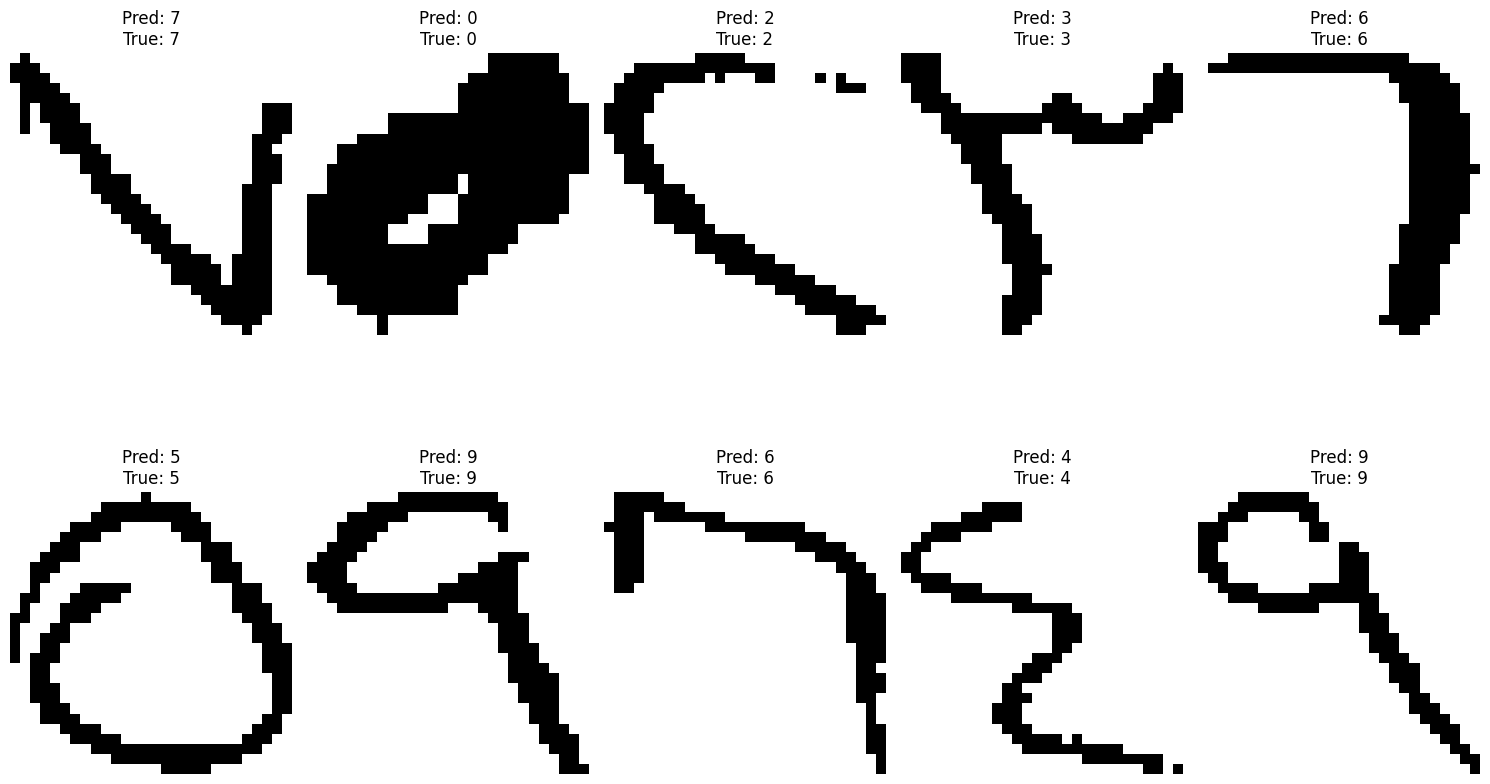

In [16]:
try:
    config = ConfigurationManager()
    val_config = config.get_validation_config()
    evaluation = Evaluation(val_config)
    evaluation.evaluation()
    evaluation.save_score()
    evaluation.predict_and_plot()

except Exception as e:
   raise e